In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
import pandas as pd

from toolbox import init, newfig

init()

SAVEDIR = (
    "/Users/leo/Workspace/phdcybersec/thesis/src/chapters/50_assessment/figures/nb15/"
)
APPENDIX_SAVEDIR = "/Users/leo/Workspace/phdcybersec/thesis/src/appendices/figures/"

## Executive Summary

- **RQ0**: Is the experiment sound?
- **RQ1**: Is the behavior of poisoning attacks predictable?
- **RQ2**: Are there hyperparameter combinations that are beneficial or detrimental in poisoning situation?
- **RQ3**: At what point do poisoning attacks start having an impact? (proportion of poisoned data/clients)
- **RQ4**: Can FL recover from poisoning attacks after model aggregation? How long does it take?
- **RQ5**: Are backdoor attacks realistic in IDS context?
- **RQ6**: Is model similarity enough to detect poisoning attacks?


## RQ6: Is model similarity enough to detect poisoning attacks?


### Test methodology

```yaml
partitioner: glob(iid_*)
+datasets: nfv2/sampled/cicids
batch_size: 512
+epochs: 100/10x10
+distribution: 10-0,9-1,5-5
+target: dos,ddos,bot,bruteforce,infiltration,untargeted
+scenario: continuous-100
seed: 1138,421,1313,5555,6567,327,2187,1977,501,3263827
```

- goal is to evaluate the impact of dataset partitioning on the similarity of models, and therefore the ability to detect poisoning attacks in such a context
- hyperparameters are fixed as the "best" ones from RQ2
- $\alpha=100$
- 3 benign-attackers distributions
  - 0% attacker to see the impact of the partitioning performance
  - 10% attackers (ie, one client) to see if his model is identifiable
  - 50% attackers to see if similar attacks are detectable
- all attacks to see if there are differences + untargeted

In [3]:
from eiffel.analysis.metrics import choices, display_choices

display_choices(choices("similarity/results/"))

similarity/results/: Not all theoritical combinations are covered: 2400 possibles, 1680 found.


Key,Values
datasets,nfv2_sampled_nb15
distribution,"5-5, 9-1, 10-0"
epochs,100_10x10
scenario,continuous-100
target,"generic, analysis, worms, backdoor, exploits, untargeted, shellcode, dos, reconnaissance, fuzzers"
batch_size,512
partitioner,"iid_drop_1, kmeans_full, kmeans_drop_2, kmeans_drop_1, iid_full, iid_drop_2, kmeans_keep_1, iid_keep_1"
seed,"501, 2187, 327, 1138, 3263827, 1977, 421, 1313, 6567, 5555"


### Partitioning effect on data distribution

- make a dataframe with the the sample numbers in each partitioning scheme
  - columns are the partitioning schemes
  - rows are tuples "{partition}-{label}"

In [4]:
import json
import re
from pathlib import Path

import pandas as pd
from eiffel.analysis.metrics import search_results

SEED = 1138

paths = search_results(
    "similarity/results/",
    scenario="continuous-100",
    target="untargeted",
    datasets=".*nb15",
    distribution="10-0",
    seed=SEED,
)

part_re = r"partitioner=(\w+),"

stats_df = pd.DataFrame()

for path in paths:
    res = re.search(part_re, path)
    assert res is not None
    partitioner = res.group(1)

    idx = []
    samples = []

    stats = next(iter(json.loads((Path(path) / "stats.json").read_text()).values()))
    for k, v in stats.items():
        part = "_".join(k.split("_")[1:])
        train_stats: dict = v.get("train")
        assert train_stats is not None

        for label in [
            "Benign",
            "Exploits",
            "Reconnaissance",
            "DoS",
            "Generic",
            "Shellcode",
            "Fuzzers",
            "Worms",
            "Backdoor",
            "Analysis",
        ]:
            idx.append(f"{part}_{label}")
            n = train_stats.get(label)
            if n is None:
                n = 0
            samples.append(n)

        s = pd.Series(samples, index=idx, name=partitioner).astype(int)

    stats_df = pd.concat([stats_df, s], axis=1)

stats_df

,iid_drop_1,iid_drop_2,iid_full,iid_keep_1,kmeans_drop_1,kmeans_drop_2,kmeans_full,kmeans_keep_1
benign_0_Benign,76807,76807,76807,76807,58251,58251,58251,58251
benign_0_Exploits,1056,1056,1056,0,1056,1056,1056,0
benign_0_Reconnaissance,428,428,428,0,428,428,428,0
benign_0_DoS,196,0,196,0,196,0,196,0
benign_0_Generic,559,559,559,0,559,559,559,0
...,...,...,...,...,...,...,...,...
benign_9_Shellcode,49,49,49,0,49,49,49,0
benign_9_Fuzzers,749,749,749,0,749,749,749,0
benign_9_Worms,0,0,6,6,0,0,6,6
benign_9_Backdoor,70,70,70,0,70,70,70,0


### Impact on the benign scenario

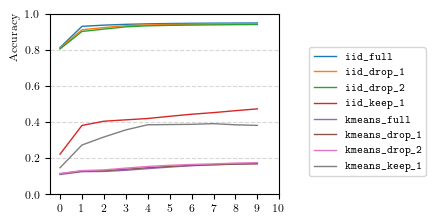

In [5]:
from functools import partial

import numpy as np
from eiffel.analysis.metrics import load_df, search_results

searchfn = partial(
    search_results,
    "similarity/results/",
    scenario="continuous-100",
    target="untargeted",
    datasets=".*nb15",
    distribution="10-0",
)

fig = newfig(width=0.45, format=4 / 3)
ax = fig.add_subplot(111)

for i, partitioner in enumerate(
    [
        "iid_full",
        "iid_drop_1",
        "iid_drop_2",
        "iid_keep_1",
        "kmeans_full",
        "kmeans_drop_1",
        "kmeans_drop_2",
        "kmeans_keep_1",
    ]
):
    data = load_df(searchfn(partitioner=partitioner), dotpath="global.f1", attr="fit")

    ax.plot(data.mean(axis=0), label=r"\texttt{" f"{partitioner}" "}")


ax.grid(axis="y", linestyle="--", alpha=0.5)
ax.set_ylabel("Accuracy", loc="top")
ax.set_yticks(np.arange(0, 1.1, 0.2))
ax.set_xticks(np.arange(0, 11, 1))

lgd = fig.legend(ncol=1, loc="right", bbox_to_anchor=(1.5, 0.5))

fig.savefig(
    SAVEDIR + "niid-perf.pdf",
    bbox_extra_artists=(lgd,),
    bbox_inches="tight",
)

In [6]:
from functools import partial

import numpy as np
from eiffel.analysis.metrics import search_results
from sklearn.decomposition import PCA

searchfn = partial(
    search_results,
    "similarity/results/",
    scenario="continuous-100",
    target="untargeted",
    datasets=".*nb15",
    distribution="10-0",
)

grads_df = pd.DataFrame()
seed_re = r"seed=(\d+)(?:,.*)?"

for partitioner in [
    "iid_full",
    "iid_drop_1",
    "iid_drop_2",
    "iid_keep_1",
    "kmeans_full",
    "kmeans_drop_1",
    "kmeans_drop_2",
    "kmeans_keep_1",
]:
    for path in searchfn(partitioner=partitioner):
        res = re.search(seed_re, path)
        assert res is not None
        seed = res.group(1)
        part_grads_dfs: list[pd.DataFrame] = [
            pd.read_pickle(p) for p in Path(path).glob("grads*.pkl")
        ]
        part_grads_df = pd.concat(part_grads_dfs, axis=0)
        part_grads_df["Partitioner"] = partitioner
        part_grads_df["Seed"] = seed
        grads_df = pd.concat([grads_df, part_grads_df], axis=0, ignore_index=True)

grads_array = np.array(grads_df["Gradients"].tolist())
grads_array = (grads_array - grads_array.mean(axis=0)) / grads_array.std(axis=0)
pca = PCA(n_components=2)
grads_pca = pca.fit_transform(grads_array)

grads_df["PCA1"] = grads_pca[:, 0]
grads_df["PCA2"] = grads_pca[:, 1]

grads_df["Client"] = grads_df["Client"].apply(lambda x: "_".join(x.split("_")[1:]))

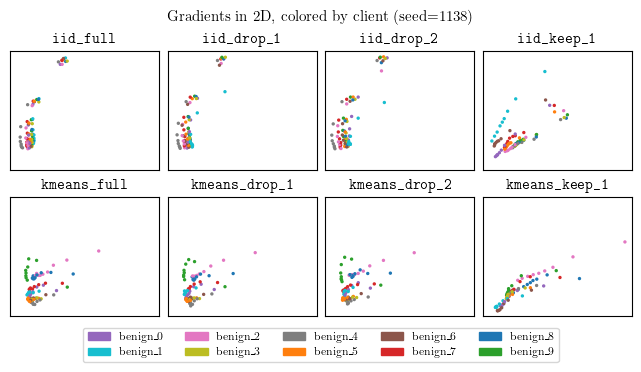

In [13]:
from typing import cast

from matplotlib import colormaps
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import NullLocator

cmap = colormaps["tab10"]

fig = newfig(2 / 1)
axs = fig.subplots(2, 4, sharex=True, sharey=True)
assert type(axs) == np.ndarray

df = grads_df  # [(grads_df["Seed"] == "1138") & (grads_df["Round"] > 1)]

levels, categories = pd.factorize(df["Client"])
df["Color"] = [cmap(i) for i in levels]
handles = [Patch(color=cmap(i), label=c) for i, c in enumerate(categories)]

for ax, partitioner in zip(axs.ravel(), df["Partitioner"].unique()):
    # figure setup
    ax.set_title(r"\texttt{%s}" % partitioner)
    ax.xaxis.set_major_locator(NullLocator())
    ax.yaxis.set_major_locator(NullLocator())

    data = df[
        (df["Partitioner"] == partitioner)
        & (grads_df["Seed"] == "1138")
        & (grads_df["Round"] > 1)
    ]

    ax.scatter(data["PCA1"], data["PCA2"], s=2, c=data["Color"])

handles = sorted(handles, key=lambda x: cast(str, x.get_label()))
lgd = fig.legend(
    handles=handles, ncol=5, loc="lower center", bbox_to_anchor=(0.5, -0.15)
)
fig.suptitle("Gradients in 2D, colored by client (seed=1138)")
fig.savefig(
    APPENDIX_SAVEDIR + "nb15-grads-per-client.pdf",
    bbox_extra_artists=(lgd,),
    bbox_inches="tight",
)

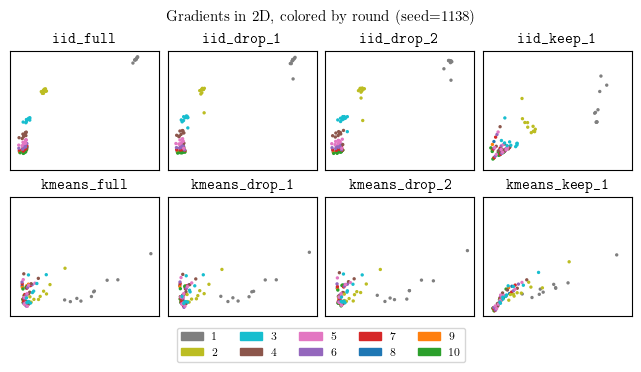

In [12]:
from typing import cast

from matplotlib import colormaps
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import NullLocator

cmap = colormaps["tab10"]

fig = newfig(2 / 1)
axs = fig.subplots(2, 4, sharex=True, sharey=True)
assert type(axs) == np.ndarray

df = grads_df  # [(grads_df["Seed"] == "1138") & (grads_df["Round"] > 1)]

levels, categories = pd.factorize(df["Round"])
df["Color"] = [cmap(i) for i in levels]
handles = [Patch(color=cmap(i), label=c) for i, c in enumerate(categories)]

for ax, partitioner in zip(axs.ravel(), df["Partitioner"].unique()):
    # figure setup
    ax.set_title(r"\texttt{%s}" % partitioner)
    ax.xaxis.set_major_locator(NullLocator())
    ax.yaxis.set_major_locator(NullLocator())

    data = df[
        (df["Partitioner"] == partitioner) & (grads_df["Seed"] == "1138")
        # & (grads_df["Round"] > 1)
    ]

    ax.scatter(data["PCA1"], data["PCA2"], s=2, c=data["Color"])

handles = sorted(handles, key=lambda x: int(cast(str, x.get_label())))
lgd = fig.legend(
    handles=handles, ncol=5, loc="lower center", bbox_to_anchor=(0.5, -0.15)
)
fig.suptitle("Gradients in 2D, colored by round (seed=1138)")
fig.savefig(
    APPENDIX_SAVEDIR + "nb15-grads-per-round.pdf",
    bbox_extra_artists=(lgd,),
    bbox_inches="tight",
)

### Identifiability of one lone attacker

In [9]:
import itertools
from functools import partial
from pathlib import Path

import pandas as pd
from eiffel.analysis.metrics import search_results

searchfn = partial(
    search_results,
    "similarity/results/",
    scenario="continuous-100",
    datasets=".*nb15",
    distribution="9-1",
)

grads_df = pd.DataFrame()

for target, partitioner, seed in itertools.product(
    [
        "untargeted",
        "exploits",
        "reconnaissance",
        "dos",
        "generic",
        "shellcode",
        "fuzzers",
        "worms",
        "backdoor",
        "analysis",
        # "injection" has been removed due to its low representation
    ],
    [
        "iid_full",
        "iid_drop_1",
        "iid_drop_2",
        "iid_keep_1",
        "kmeans_full",
        "kmeans_drop_1",
        "kmeans_drop_2",
        "kmeans_keep_1",
    ],
    [1138, 421, 1313, 5555, 6567, 327, 2187, 1977, 501, 3263827],
):
    print(f"Loading: {target}, {partitioner}, {seed}")

    paths = searchfn(partitioner=partitioner, target=target, seed=seed)
    assert len(paths) == 1
    path = paths[0]
    part_grads_dfs: list[pd.DataFrame] = [
        pd.read_pickle(p) for p in Path(path).glob("grads*.pkl")
    ]
    assert part_grads_dfs[0].shape[0] == 10  # ten client per partition
    assert len(part_grads_dfs) == 10  # ten clients

    part_grads_df = pd.concat(part_grads_dfs, axis=0, ignore_index=True)
    part_grads_df["Partitioner"] = partitioner
    part_grads_df["Target"] = target
    part_grads_df["Seed"] = seed

    grads_df = pd.concat([grads_df, part_grads_df], axis=0, ignore_index=True)

print("Loaded all gradients")


grads_df["Client"] = grads_df["Client"].apply(lambda x: "_".join(x.split("_")[1:]))

Loading: untargeted, iid_full, 1138
Loading: untargeted, iid_full, 421
Loading: untargeted, iid_full, 1313
Loading: untargeted, iid_full, 5555
Loading: untargeted, iid_full, 6567
Loading: untargeted, iid_full, 327
Loading: untargeted, iid_full, 2187
Loading: untargeted, iid_full, 1977
Loading: untargeted, iid_full, 501
Loading: untargeted, iid_full, 3263827
Loading: untargeted, iid_drop_1, 1138
Loading: untargeted, iid_drop_1, 421
Loading: untargeted, iid_drop_1, 1313
Loading: untargeted, iid_drop_1, 5555
Loading: untargeted, iid_drop_1, 6567
Loading: untargeted, iid_drop_1, 327
Loading: untargeted, iid_drop_1, 2187
Loading: untargeted, iid_drop_1, 1977
Loading: untargeted, iid_drop_1, 501
Loading: untargeted, iid_drop_1, 3263827
Loading: untargeted, iid_drop_2, 1138
Loading: untargeted, iid_drop_2, 421
Loading: untargeted, iid_drop_2, 1313
Loading: untargeted, iid_drop_2, 5555
Loading: untargeted, iid_drop_2, 6567
Loading: untargeted, iid_drop_2, 327
Loading: untargeted, iid_drop_2, 2

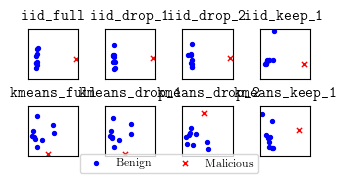

In [10]:
from matplotlib.axes import Axes
from matplotlib.ticker import NullLocator
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import StandardScaler

fig = newfig(2 / 1, width=0.8)
axs = fig.subplots(2, 4, sharex=True, sharey=True)
assert type(axs) == np.ndarray

df = grads_df

for ax, partitioner in zip(axs.ravel(), df["Partitioner"].unique()):
    ax: Axes
    # figure setup
    ax.set_title(r"\texttt{%s}" % partitioner)
    ax.set_box_aspect(1)
    ax.xaxis.set_major_locator(NullLocator())
    ax.yaxis.set_major_locator(NullLocator())

    data = df[
        (df["Partitioner"] == partitioner)
        & (df["Target"] == "untargeted")
        & (df["Seed"] == 1138)
        # & (df["Round"] > 1)
        & (df["Round"] == 10)
    ]

    grads_array = np.array(data["Gradients"].tolist())
    grads_array = StandardScaler().fit_transform(grads_array)
    grads_pca = PCA(n_components=2).fit_transform(grads_array)

    benign = grads_pca[data["Client"].str.contains("benign")]
    ax.scatter(benign[:, 0], benign[:, 1], s=8, c="blue", label="Benign")

    malicious = grads_pca[~data["Client"].str.contains("benign")]
    ax.scatter(
        malicious[:, 0], malicious[:, 1], s=14, marker="x", c="red", label="Malicious"
    )

handles, labels = axs.ravel()[-1].get_legend_handles_labels()
lgd = fig.legend(
    handles=handles, ncol=5, loc="lower center", bbox_to_anchor=(0.5, -0.12)
)
fig.savefig(
    SAVEDIR + "similarity-untargeted-single.pdf",
    bbox_extra_artists=(lgd,),
    bbox_inches="tight",
)

/var/folders/6v/8wy9dm6938n6yt0_hkf53crr0000gn/T/ipykernel_13031/4171756478.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["PCA1"] = grads_pca[:, 0]
/var/folders/6v/8wy9dm6938n6yt0_hkf53crr0000gn/T/ipykernel_13031/4171756478.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["PCA2"] = grads_pca[:, 1]
/var/folders/6v/8wy9dm6938n6yt0_hkf53crr0000gn/T/ipykernel_13031/4171756478.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

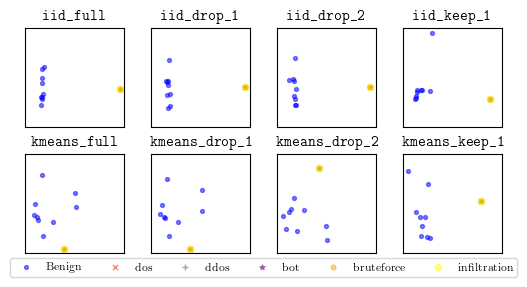

In [11]:
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from matplotlib.ticker import NullLocator
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import StandardScaler

fig = newfig(2 / 1, width=0.8)
axs = fig.subplots(2, 4, sharex=True, sharey=True)
assert type(axs) == np.ndarray

df = grads_df


for ax, partitioner in zip(axs.ravel(), df["Partitioner"].unique()):
    ax: Axes
    # figure setup
    ax.set_title(r"\texttt{%s}" % partitioner)
    ax.set_box_aspect(1)
    ax.xaxis.set_major_locator(NullLocator())
    ax.yaxis.set_major_locator(NullLocator())

    data = df[
        (df["Partitioner"] == partitioner)
        & (df["Target"] == "untargeted")
        & (df["Seed"] == 1138)
        # & (df["Round"] > 1)
        & (df["Round"] == 10)
    ]

    grads_array = np.array(data["Gradients"].tolist())
    grads_array = StandardScaler().fit_transform(grads_array)
    grads_pca = PCA(n_components=2).fit_transform(grads_array)
    data["PCA1"] = grads_pca[:, 0]
    data["PCA2"] = grads_pca[:, 1]

    benign = data[data["Client"].str.contains("benign")]
    ax.scatter(
        benign["PCA1"], benign["PCA2"], s=8, color="blue", label="Benign", alpha=0.5
    )

    malicious = data[~data["Client"].str.contains("benign")]
    for label, c, m in zip(
        ["dos", "ddos", "bot", "bruteforce", "infiltration"],
        ["red", "green", "purple", "orange", "yellow"],
        ["x", "+", "*", "h", "D"],
    ):
        target = malicious[malicious["Target"] == label]
        ax.scatter(
            malicious["PCA1"],
            malicious["PCA2"],
            s=14,
            marker=m,
            color=c,
            label=label,
            alpha=0.5,
        )

handles, labels = axs.ravel()[-1].get_legend_handles_labels()
lgd = fig.legend(
    handles=handles,
    labels=labels,
    ncol=6,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.1),
)

### Detectability of similar attacks

In [12]:
import itertools
from functools import partial
from pathlib import Path

import pandas as pd
from eiffel.analysis.metrics import search_results

searchfn = partial(
    search_results,
    "similarity/results/",
    scenario="continuous-100",
    datasets=".*nb15",
    distribution="5-5",
)

grads_df = pd.DataFrame()

for target, partitioner, seed in itertools.product(
    [
        "untargeted",
        "exploits",
        "reconnaissance",
        "dos",
        "generic",
        "shellcode",
        "fuzzers",
        "worms",
        "backdoor",
        "analysis",
    ],
    [
        "iid_full",
        "iid_drop_1",
        "iid_drop_2",
        "iid_keep_1",
        "kmeans_full",
        "kmeans_drop_1",
        "kmeans_drop_2",
        "kmeans_keep_1",
    ],
    [1138, 421, 1313, 5555, 6567, 327, 2187, 1977, 501, 3263827],
):
    print(f"Loading: {target}, {partitioner}, {seed}")

    paths = searchfn(partitioner=partitioner, target=target, seed=seed)
    assert len(paths) == 1
    path = paths[0]
    part_grads_dfs: list[pd.DataFrame] = [
        pd.read_pickle(p) for p in Path(path).glob("grads*.pkl")
    ]
    assert part_grads_dfs[0].shape[0] == 10  # ten client per partition
    assert len(part_grads_dfs) == 10  # ten clients

    part_grads_df = pd.concat(part_grads_dfs, axis=0, ignore_index=True)
    part_grads_df["Partitioner"] = partitioner
    part_grads_df["Target"] = target
    part_grads_df["Seed"] = seed

    grads_df = pd.concat([grads_df, part_grads_df], axis=0, ignore_index=True)

print("Loaded all gradients")


grads_df["Client"] = grads_df["Client"].apply(lambda x: "_".join(x.split("_")[1:]))

Loading: untargeted, iid_full, 1138
Loading: untargeted, iid_full, 421
Loading: untargeted, iid_full, 1313
Loading: untargeted, iid_full, 5555
Loading: untargeted, iid_full, 6567
Loading: untargeted, iid_full, 327
Loading: untargeted, iid_full, 2187
Loading: untargeted, iid_full, 1977
Loading: untargeted, iid_full, 501
Loading: untargeted, iid_full, 3263827
Loading: untargeted, iid_drop_1, 1138
Loading: untargeted, iid_drop_1, 421
Loading: untargeted, iid_drop_1, 1313
Loading: untargeted, iid_drop_1, 5555
Loading: untargeted, iid_drop_1, 6567
Loading: untargeted, iid_drop_1, 327
Loading: untargeted, iid_drop_1, 2187
Loading: untargeted, iid_drop_1, 1977
Loading: untargeted, iid_drop_1, 501
Loading: untargeted, iid_drop_1, 3263827
Loading: untargeted, iid_drop_2, 1138
Loading: untargeted, iid_drop_2, 421
Loading: untargeted, iid_drop_2, 1313
Loading: untargeted, iid_drop_2, 5555
Loading: untargeted, iid_drop_2, 6567
Loading: untargeted, iid_drop_2, 327
Loading: untargeted, iid_drop_2, 2

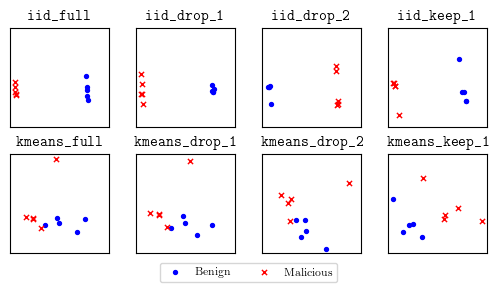

In [ ]:
from matplotlib.axes import Axes
from matplotlib.ticker import NullLocator
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import StandardScaler

fig = newfig(2 / 1, width=0.8)
axs = fig.subplots(2, 4, sharex=True, sharey=True)
assert type(axs) == np.ndarray

df = grads_df

for ax, partitioner in zip(axs.ravel(), df["Partitioner"].unique()):
    ax: Axes
    # figure setup
    ax.set_title(r"\texttt{%s}" % partitioner)
    ax.set_box_aspect(1)
    ax.xaxis.set_major_locator(NullLocator())
    ax.yaxis.set_major_locator(NullLocator())

    data = df[
        (df["Partitioner"] == partitioner)
        & (df["Target"] == "untargeted")
        & (df["Seed"] == 1138)
        # & (df["Round"] > 1)
        & (df["Round"] == 10)
    ]

    grads_array = np.array(data["Gradients"].tolist())
    grads_array = StandardScaler().fit_transform(grads_array)
    grads_pca = PCA(n_components=2).fit_transform(grads_array)

    benign = grads_pca[data["Client"].str.contains("benign")]
    ax.scatter(benign[:, 0], benign[:, 1], s=8, c="blue", label="Benign")

    malicious = grads_pca[~data["Client"].str.contains("benign")]
    ax.scatter(
        malicious[:, 0], malicious[:, 1], s=14, marker="x", c="red", label="Malicious"
    )

handles, labels = axs.ravel()[-1].get_legend_handles_labels()
lgd = fig.legend(
    handles=handles, ncol=5, loc="lower center", bbox_to_anchor=(0.5, -0.12)
)
fig.savefig(
    SAVEDIR + "similarity-untargeted-colluding.pdf",
    bbox_extra_artists=(lgd,),
    bbox_inches="tight",
)

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.ticker import NullLocator

fig, axs = plt.subplots(
    2,
    4,
    figsize=figsize(1, 0.5, two_column=True),
    constrained_layout=True,
    sharex=True,
    sharey=True,
)

df = grads_df[
    (grads_df["Target"] != "untargeted")
    # & (grads_df["Round"] == 10)
    & (grads_df["Seed"] == 1138)
]

for ax, partitioner in zip(axs.ravel(), df["Partitioner"].unique()):
    # figure setup
    ax.set_title(partitioner, pad=-10)
    ax.xaxis.set_major_locator(NullLocator())
    ax.yaxis.set_major_locator(NullLocator())

    data = df[df["Partitioner"] == partitioner]

    benign = data[data["Client"].str.contains("benign")]
    ax.scatter(
        benign["PCA1"], benign["PCA2"], s=1, color="blue", label="Benign", alpha=0.5
    )

    malicious = data[~data["Client"].str.contains("benign")]
    for label, c in zip(
        [
            "exploits",
            "reconnaissance",
            "dos",
            "generic",
            "shellcode",
            "fuzzers",
            "worms",
            "backdoor",
            "analysis",
        ],
        ["red", "green", "purple", "orange", "yellow", "brown", "pink", "gray", "cyan"],
    ):
        target = malicious[malicious["Target"] == label]
        ax.scatter(
            malicious["PCA1"], malicious["PCA2"], s=1, color=c, label=label, alpha=0.5
        )

handles, labels = axs.ravel()[-1].get_legend_handles_labels()
lgd = fig.legend(
    handles=handles,
    labels=labels,
    ncol=6,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.1),
)
fig.suptitle("Gradients in 2D, colored by malicious target")

NameError: name 'figsize' is not defined